# 월마트 리테일 상품 판매량 예측 (Estimate the unit sales of Walmart retail goods)

<img src="../img/kaggle-m5-overview.png"/>

# 1a.EDA-Introduction

- Estimate the unit sales of Walmart retail goods
- From 2011-01-29 to 2016-06-19

# Dataset
- calendar.csv - 제품들이 팔린 날짜들 (df_calendar)
- sales_train_validation.csv - 제품과 매장에 따른 과거 일일 판매 데이터 [d_1 - d_1913] (df_sales)
- sell_prices.csv - 매장 및 날짜별로 판매되는 제품의 가격에 대한 정보 (df_prices)
- sales_train_evaluation.csv - Available once month before competition deadline. Will include sales [d_1 - d_1941]
- sample_submission.csv - The correct format for submissions. Reference the Evaluation tab for more info. (df_sub)

<img src="../img/data-overview-01.png" align="left">
<img src="../img/data-overview-02.png" align="left">

## Import Dataset
### 필요한 Library Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import os
from itertools import cycle
import warnings

%matplotlib inline

warnings.simplefilter("ignore", DeprecationWarning)
warnings.simplefilter("ignore", FutureWarning, )

### Download datasets

In [2]:
!mkdir data
!wget -O ./data/kaggle-m5.zip https://sagemaker-sinjoonk.s3.amazonaws.com/kaggle/kaggle-m5.zip
!unzip ./data/kaggle-m5.zip

--2020-04-14 01:09:38--  https://sagemaker-sinjoonk.s3.amazonaws.com/kaggle/kaggle-m5.zip
Resolving sagemaker-sinjoonk.s3.amazonaws.com (sagemaker-sinjoonk.s3.amazonaws.com)... 52.216.249.196
Connecting to sagemaker-sinjoonk.s3.amazonaws.com (sagemaker-sinjoonk.s3.amazonaws.com)|52.216.249.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32273861 (31M) [application/zip]
Saving to: ‘./data/kaggle-m5.zip’

./data/kaggle-m5.zi 100%[===================>]  30.78M  36.7MB/s    in 0.8s    

2020-04-14 01:09:39 (36.7 MB/s) - ‘./data/kaggle-m5.zip’ saved [32273861/32273861]

Archive:  ./data/kaggle-m5.zip
  inflating: data/calendar.csv       
  inflating: data/sales_train_validation.csv  
  inflating: data/sample_submission.csv  
  inflating: data/sell_prices.csv    


In [3]:
# Create Dataframes
df_sales = pd.read_csv("./data/sales_train_validation.csv")
df_prices = pd.read_csv("./data/sell_prices.csv")
df_calendar = pd.read_csv("./data/calendar.csv")

# sales_train_validation(df_sales)

Contains the historical daily unit sales data per product and store [d_1 - d_1913].

- item_id: The id of the product.
- dept_id: The id of the department the product belongs to.
- cat_id: The id of the category the product belongs to.
- store_id: The id of the store where the product is sold.
- state_id: The State where the store is located.
- d_1, d_2, ..., d_i, ... d_1941: The number of units sold at day i, starting from 2011-01-29.

In [4]:
df_sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [5]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30490 entries, 0 to 30489
Columns: 1919 entries, id to d_1913
dtypes: int64(1913), object(6)
memory usage: 446.4+ MB


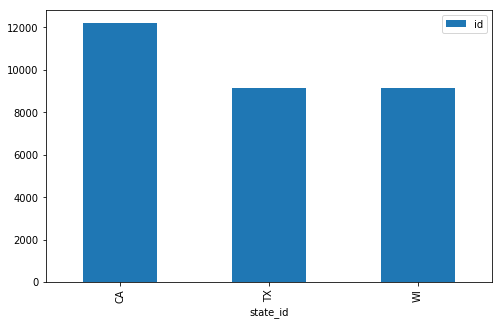

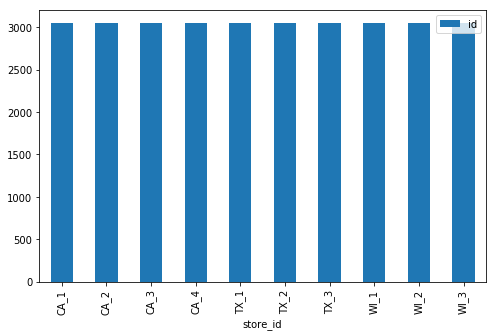

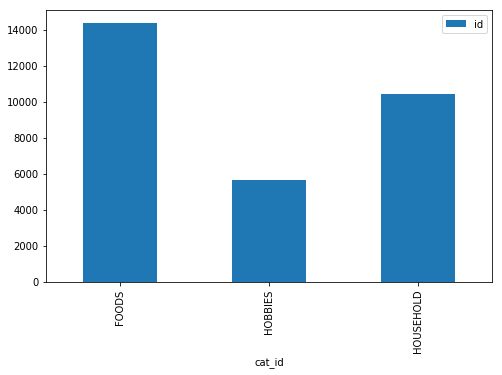

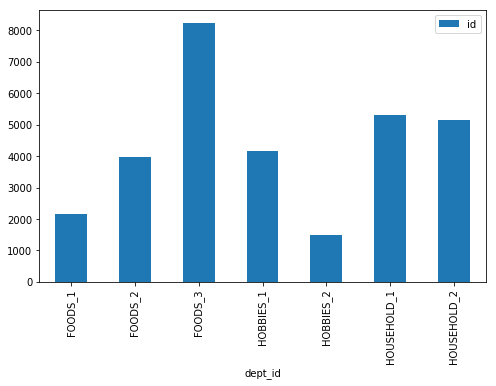

In [6]:
# "state_id", "store_id", "cat_id", "dept_id" 별 Id 집계

titles = ["state_id", "store_id", "cat_id", "dept_id"]
for title in titles:
    df_sales.groupby(title)["id"].count().reset_index().plot.bar(x=title, figsize=(8,5))

- Observation
    - 각 Store 가 파는 item 갯수는 동일하다.
    - `FOODS` category 가 가장 많이 팔린다.
    - `FOODS` category 에서는 그 중 `FOODS_3`dept_id가 가장 많이 팔린다.

In [7]:
# NaN 확인
df_sales.isnull().values.any()

False

### 판매량 확인 ("state_id", "store_id", "cat_id", "dept_id")

In [8]:
# d_로 시작하는 column 추출
d_cols = [c for c in df_sales.columns if 'd_' in c]

# d_로 시작하는 column의 value(판매량)들을 더해 "sales_total" column에 추가
df_sales["sales_total"] = df_sales.loc[:,d_cols].sum(axis=1)

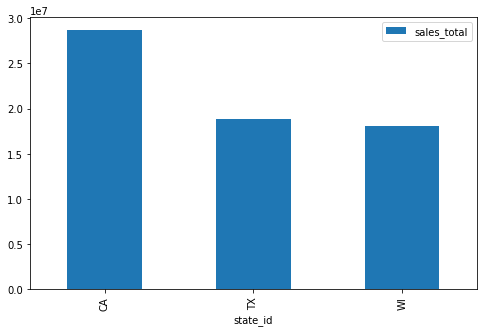

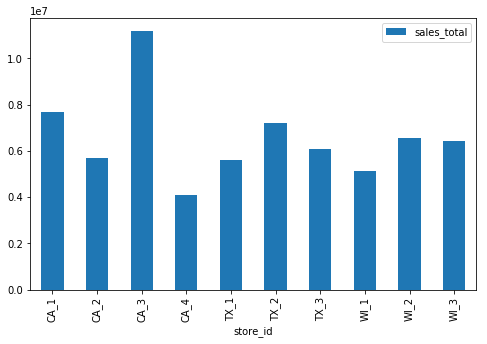

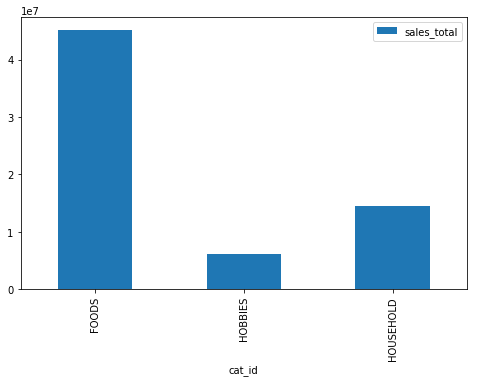

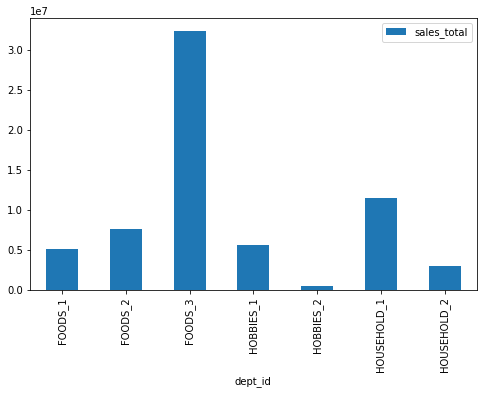

In [9]:
titles = ["state_id", "store_id", "cat_id", "dept_id"]
for title in titles:
    df_sales.groupby(title)["sales_total"].sum().reset_index().plot.bar(x=title, figsize=(8,5))

- Observations
    - CA (California)의 sales_total이 가장 크다.
    - FOODS category sales_total이 가장 크다.
    - FOODS category 중에서는 dept_id FOODS_3의 sales_total이 가장 크다.

# Calendar (df_calendar)
Contains the dates on which products are sold. The dates are in a yyyy/dd/mm format.

- date: The date in a “y-m-d” format.
- wm_yr_wk: The id of the week the date belongs to.
- weekday: The type of the day (Saturday, Sunday, ..., Friday).
- wday: The id of the weekday, starting from Saturday.
- month: The month of the date.
- year: The year of the date.
- d : Sequence
- event_name_1: If the date includes an event, the name of this event.
- event_type_1: If the date includes an event, the type of this event.
- event_name_2: If the date includes a second event, the name of this event.
- event_type_2: If the date includes a second event, the type of this event.
- snap_CA, snap_TX, and snap_WI: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP 3 purchases on the examined date. 1 indicates that SNAP purchases are allowed.

In [10]:
print(df_calendar.min())
print(df_calendar.max())

date        2011-01-29
wm_yr_wk         11101
weekday         Friday
wday                 1
month                1
year              2011
d                  d_1
snap_CA              0
snap_TX              0
snap_WI              0
dtype: object
date        2016-06-19
wm_yr_wk         11621
weekday      Wednesday
wday                 7
month               12
year              2016
d                d_999
snap_CA              1
snap_TX              1
snap_WI              1
dtype: object


In [11]:
df_calendar.head(5)

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [12]:
df_calendar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1969 entries, 0 to 1968
Data columns (total 14 columns):
date            1969 non-null object
wm_yr_wk        1969 non-null int64
weekday         1969 non-null object
wday            1969 non-null int64
month           1969 non-null int64
year            1969 non-null int64
d               1969 non-null object
event_name_1    162 non-null object
event_type_1    162 non-null object
event_name_2    5 non-null object
event_type_2    5 non-null object
snap_CA         1969 non-null int64
snap_TX         1969 non-null int64
snap_WI         1969 non-null int64
dtypes: int64(7), object(7)
memory usage: 215.4+ KB


- Observation : event관련 column을 제외하고는 NaN 값이 없다.

### Event 정보

In [13]:
# Event이름 추출
df_calendar["event_name_1"].unique()

array([nan, 'SuperBowl', 'ValentinesDay', 'PresidentsDay', 'LentStart',
       'LentWeek2', 'StPatricksDay', 'Purim End', 'OrthodoxEaster',
       'Pesach End', 'Cinco De Mayo', "Mother's day", 'MemorialDay',
       'NBAFinalsStart', 'NBAFinalsEnd', "Father's day",
       'IndependenceDay', 'Ramadan starts', 'Eid al-Fitr', 'LaborDay',
       'ColumbusDay', 'Halloween', 'EidAlAdha', 'VeteransDay',
       'Thanksgiving', 'Christmas', 'Chanukah End', 'NewYear',
       'OrthodoxChristmas', 'MartinLutherKingDay', 'Easter'], dtype=object)

- Observation : NBAFinalsStart, NBAFinalsStop는 기간 이벤트다.

In [14]:
df_calendar[df_calendar["event_name_1"].isin(["NBAFinalsStart", "NBAFinalsEnd"])]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
122,2011-05-31,11118,Tuesday,4,5,2011,d_123,NBAFinalsStart,Sporting,NaN,NaN,0,0,0
134,2011-06-12,11120,Sunday,2,6,2011,d_135,NBAFinalsEnd,Sporting,NaN,NaN,0,1,1
500,2012-06-12,11220,Tuesday,4,6,2012,d_501,NBAFinalsStart,Sporting,NaN,NaN,0,1,1
509,2012-06-21,11221,Thursday,6,6,2012,d_510,NBAFinalsEnd,Sporting,NaN,NaN,0,0,0
859,2013-06-06,11319,Thursday,6,6,2013,d_860,NBAFinalsStart,Sporting,NaN,NaN,1,1,1
873,2013-06-20,11321,Thursday,6,6,2013,d_874,NBAFinalsEnd,Sporting,NaN,NaN,0,0,0
1223,2014-06-05,11418,Thursday,6,6,2014,d_1224,NBAFinalsStart,Sporting,NaN,NaN,1,1,1
1233,2014-06-15,11420,Sunday,2,6,2014,d_1234,NBAFinalsEnd,Sporting,Father's day,Cultural,0,1,1
1587,2015-06-04,11518,Thursday,6,6,2015,d_1588,NBAFinalsStart,Sporting,NaN,NaN,1,0,0
1599,2015-06-16,11520,Tuesday,4,6,2015,d_1600,NBAFinalsEnd,Sporting,NaN,NaN,0,0,0


In [15]:
df_calendar[df_calendar["wm_yr_wk"] == 11118]

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
119,2011-05-28,11118,Saturday,1,5,2011,d_120,NaN,NaN,NaN,NaN,0,0,0
120,2011-05-29,11118,Sunday,2,5,2011,d_121,NaN,NaN,NaN,NaN,0,0,0
121,2011-05-30,11118,Monday,3,5,2011,d_122,MemorialDay,National,NaN,NaN,0,0,0
122,2011-05-31,11118,Tuesday,4,5,2011,d_123,NBAFinalsStart,Sporting,NaN,NaN,0,0,0
123,2011-06-01,11118,Wednesday,5,6,2011,d_124,NaN,NaN,NaN,NaN,1,1,0
124,2011-06-02,11118,Thursday,6,6,2011,d_125,NaN,NaN,NaN,NaN,1,0,1
125,2011-06-03,11118,Friday,7,6,2011,d_126,NaN,NaN,NaN,NaN,1,1,1


- Observation : NBA Final Event는 대략 2주 정도 지속된다.

In [16]:
# "event_name_1"는 총 162번, "event_name_2"는 총 5번 

print("# of event_name_1 : {}".format(df_calendar["event_name_1"].notnull().sum()))
print("# of event_name_2 : {}".format(df_calendar["event_name_2"].notnull().sum()))
print("Event ratio(%) : {:.2%}".format(df_calendar["event_name_1"].notnull().sum()/len(df_calendar)))

# of event_name_1 : 162
# of event_name_2 : 5
Event ratio(%) : 8.23%


# sell_prices (df_prices)
Contains information about the price of the products sold per store and date.

- store_id: The id of the store where the product is sold.
- item_id: The id of the product.
- wm_yr_wk: The id of the week.
- sell_price: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

In [17]:
df_prices.head(5)

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [18]:
df_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6841121 entries, 0 to 6841120
Data columns (total 4 columns):
store_id      object
item_id       object
wm_yr_wk      int64
sell_price    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 208.8+ MB


In [19]:
df_prices.min()

store_id             CA_1
item_id       FOODS_1_001
wm_yr_wk            11101
sell_price           0.01
dtype: object

In [20]:
df_prices.groupby("item_id").min().reset_index().head(20)

,item_id,store_id,wm_yr_wk,sell_price
0,FOODS_1_001,CA_1,11101,0.99
1,FOODS_1_002,CA_1,11101,7.66
2,FOODS_1_003,CA_1,11101,2.50
3,FOODS_1_004,CA_1,11206,1.50
4,FOODS_1_005,CA_1,11101,0.10
5,FOODS_1_006,CA_1,11101,1.97
6,FOODS_1_008,CA_1,11138,0.50
7,FOODS_1_009,CA_1,11206,0.99
8,FOODS_1_010,CA_1,11114,4.09
9,FOODS_1_011,CA_1,11101,1.19


- Observations
    - `df_prices`내 `wm_yr_wk`의 최소값은 11,101
    - `FOODS_1_004`는 `wm_yr_wk`의 최소값이 11,206 : 11,101 ~ 11,205 주 까지는 판매되지 않았다.